# Tutorial: Advection Equation with data driven DeepONet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial24/tutorial.ipynb)


> ##### ⚠️ ***Before starting:***
> We assume you are already familiar with the concepts covered in the [Getting started with PINA](https://mathlab.github.io/PINA/_tutorial.html#getting-started-with-pina) tutorials. If not, we strongly recommend reviewing them before exploring this advanced topic.

In this tutorial, we demonstrate how to solve the advection operator learning problem using `DeepONet`. We follow the original formulation of Lu *et al.* in [*DeepONet: Learning nonlinear operators for identifying differential equations based on the universal approximation theorem of operator*](https://arxiv.org/abs/1910.03193).

We begin by importing the necessary modules.

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"
    # get the data
    !mkdir "data"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial24/data/advection_input_testing.pt" -O "data/advection_input_testing.pt"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial24/data/advection_input_training.pt" -O "data/advection_input_training.pt"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial24/data/advection_output_testing.pt" -O "data/advection_output_testing.pt"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial24/data/advection_output_training.pt" -O "data/advection_output_training.pt"

import matplotlib.pyplot as plt
import torch
import warnings


from pina import Trainer, LabelTensor
from pina.model import FeedForward, DeepONet
from pina.solver import SupervisedSolver
from pina.problem.zoo import SupervisedProblem
from pina.loss import LpLoss

warnings.filterwarnings("ignore")

## Advection problem and data preparation

We consider the 1D advection equation
$$
\frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0, 
\quad x \in [0,2], \; t \in [0,1],
$$
with periodic boundary conditions. The initial condition is chosen as a Gaussian pulse centered at a random location
$\mu \sim U(0.05, 1)$ and with variance $\sigma^2 = 0.02$:
$$
u_0(x) = \frac{1}{\sqrt{\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}, 
\quad x \in [0,2].
$$

Our goal is to learn the operator
$$
\mathcal{G}: u_0(x) \mapsto u(x, t = \delta) = u_0(x - \delta),
$$
with $\delta = 0.5$ for this tutorial. In practice, this means learning a mapping from the initial condition to the solution at a fixed later time.  
The dataset therefore consists of trajectories where inputs are initial profiles and outputs are the same profiles shifted by $\delta$.

The data has shape `[T, Nx, D]`, where:
- `T` — number of trajectories (100 for training, 1000 for testing),
- `Nx` — number of spatial grid points (fixed at 100),
- `D = 1` — single scalar field value `u`.

We now load the dataset and visualize sample trajectories.

In [2]:
# loading training data
data_0_training = LabelTensor(
    torch.load("data/advection_input_training.pt", weights_only=False),
    labels="u0",
)
data_dt_training = LabelTensor(
    torch.load("data/advection_output_training.pt", weights_only=False),
    labels="u",
)

# loading testing data
data_0_testing = LabelTensor(
    torch.load("data/advection_input_testing.pt", weights_only=False),
    labels="u0",
)
data_dt_testing = LabelTensor(
    torch.load("data/advection_output_testing.pt", weights_only=False),
    labels="u",
)

The data are loaded, let's visualize a few of the initial conditions!

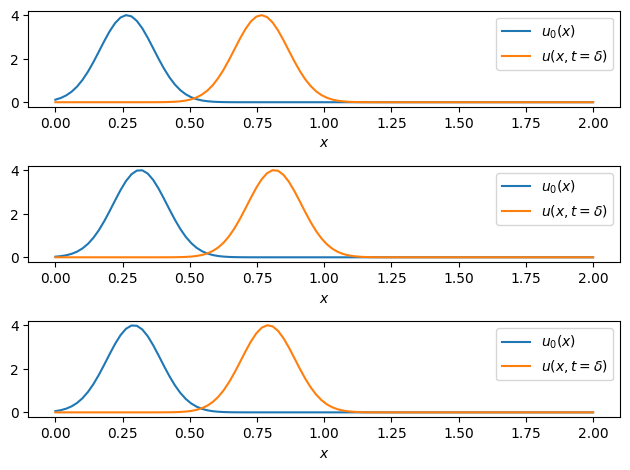

In [3]:
# storing the discretization in space:
Nx = data_0_training.shape[1]

for idx, i in enumerate(torch.randint(0, data_0_training.shape[0] - 1, (3,))):
    u0 = data_0_training[int(i)].extract("u0")
    u = data_dt_training[int(i)].extract("u")
    x = torch.linspace(
        0, 2, Nx
    )  # the discretization in the spatial dimension is fixed
    plt.subplot(3, 1, idx + 1)
    plt.plot(x, u0.flatten(), label=rf"$u_0(x)$")
    plt.plot(x, u.flatten(), label=rf"$u(x, t=\delta)$")
    plt.xlabel(rf"$x$")
    plt.tight_layout()
    plt.legend()

Great — we have generated a traveling wave and visualized a few samples. Next, we will use this data to train a `DeepONet`.

## DeepONet

The standard `DeepONet` architecture consists of two subnetworks: a **branch** network and a **trunk** network (see figure below).

<center>
<img src="http://raw.githubusercontent.com/mathLab/PINA/master/tutorials/static/deeponet.png" alt="image from: Moya, C.; Lin, G. Fed-DeepONet: Stochastic Gradient-Based Federated Training of Deep Operator Networks. Algorithms 2022, 15, 325. https://doi.org/10.3390/a15090325" style="width:50%; height:50%;"/>
</center>
<center>
<i>Image source: Moya & Lin (2022)</i>
</center>

In our setting:
- The **branch network** receives the initial condition of each trajectory, with input shape `[B, Nx]` — where `B` is the batch size and `Nx` the spatial discretization points of the field at \( t = 0 \).
- The **trunk network** takes input of shape `[B, 1]`, corresponding to the location at which we evaluate the solution (in this 1D case, the spatial coordinate).

Together, these networks learn the mapping from the initial field to the solution at a later time.

We now define and train the model for the advection problem.

In [4]:
problem = SupervisedProblem(
    input_=data_0_training,
    output_=data_dt_training,
    input_variables=data_0_training.labels,
    output_variables=data_dt_training.labels,
)

We now proceede to create the trunk and branch networks.

In [5]:
# create Trunk model
class TrunkNet(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.trunk = FeedForward(**kwargs)

    def forward(self, x):
        t = (
            torch.zeros(size=(x.shape[0], 1), requires_grad=False) + 0.5
        )  # create an input of only 0.5
        return self.trunk(t)


# create Branch model
class BranchNet(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.branch = FeedForward(**kwargs)

    def forward(self, x):
        return self.branch(x.flatten(1))

The `TrunkNet` is implemented as a standard `FeedForward` network with a slightly modified `forward` method. In this case, the trunk network simply outputs a tensor filled with the value \(0.5\), repeated for each trajectory — corresponding to evaluating the solution at time \(t = 0.5\).

The `BranchNet` is also a `FeedForward` network, but its `forward` pass first flattens the input along the last dimension. This produces a vector of length `Nx`, representing the sampled initial condition at the sensor locations.

With both subnetworks defined, we can now instantiate the DeepONet model using the `DeepONet` class from `pina.model`.

In [6]:
# initialize truck and branch net
trunk = TrunkNet(
    layers=[256] * 4,
    output_dimensions=Nx,
    input_dimensions=1,  # time variable dimension
    func=torch.nn.ReLU,
)
branch = BranchNet(
    layers=[256] * 4,
    output_dimensions=Nx,
    input_dimensions=Nx,  # spatial variable dimension
    func=torch.nn.ReLU,
)

# initialize the DeepONet model
model = DeepONet(
    branch_net=branch,
    trunk_net=trunk,
    input_indeces_branch_net=["u0"],
    input_indeces_trunk_net=["u0"],
    reduction="id",
    aggregator="*",
)

The aggregation and reduction functions combine the outputs of the branch and trunk networks. In this example, their outputs are multiplied element-wise, and no reduction is applied — meaning the final output has the same dimensionality as each network’s output.

We train the model using a `SupervisedSolver` with an `MSE` loss. Below, we first define the solver and then the trainer used to run the optimization.

In [7]:
# define solver
solver = SupervisedSolver(problem=problem, model=model)

# define the trainer and train
trainer = Trainer(
    solver=solver, max_epochs=200, enable_model_summary=False, accelerator="cpu"
)
trainer.train()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Let's see the final train and test errors:

In [8]:
# the l2 error
l2 = LpLoss()

with torch.no_grad():
    train_err = l2(trainer.solver(data_0_training), data_dt_training)
    test_err = l2(trainer.solver(data_0_testing), data_dt_testing)

print(f"Training error: {float(train_err.mean()):.2%}")
print(f"Testing error: {float(test_err.mean()):.2%}")

Training error: 0.75%
Testing error: 1.43%


We can see that the testing error is slightly higher than the training one, maybe due to overfitting. We now plot some results trajectories.

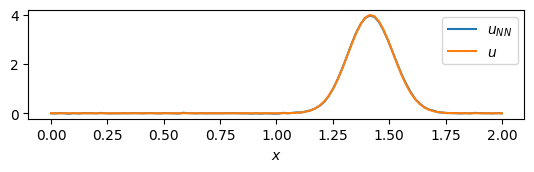

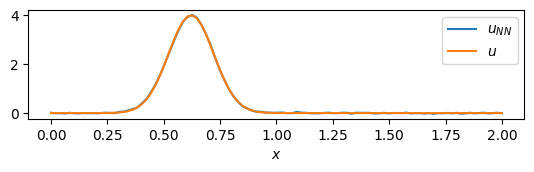

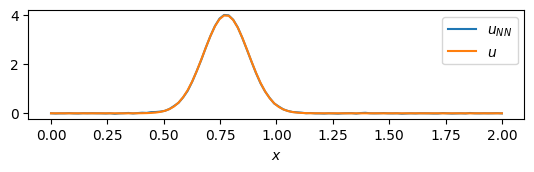

In [9]:
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.plot(
        torch.linspace(0, 2, Nx),
        solver(data_0_training)[10 * i].detach().flatten(),
        label=r"$u_{NN}$",
    )
    plt.plot(
        torch.linspace(0, 2, Nx),
        data_dt_training[10 * i].extract("u").flatten(),
        label=r"$u$",
    )
    plt.xlabel(r"$x$")
    plt.legend(loc="upper right")
    plt.show()

As we can see, they are barely indistinguishable. To better understand the difference, we now plot the residuals, i.e. the difference of the exact solution and the predicted one. 

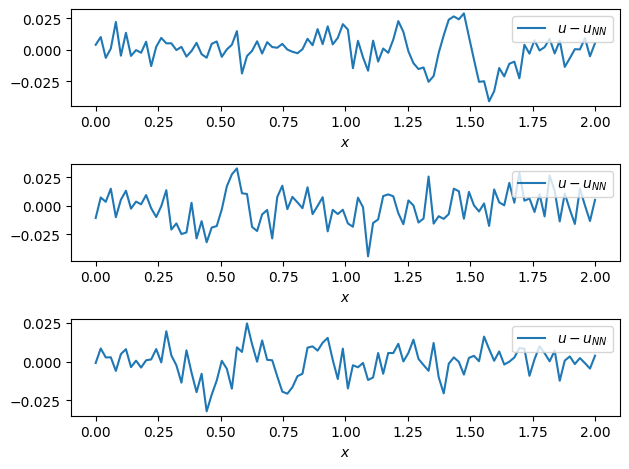

In [10]:
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.plot(
        torch.linspace(0, 2, Nx),
        data_dt_training[10 * i].extract("u").flatten()
        - solver(data_0_training)[10 * i].detach().flatten(),
        label=r"$u - u_{NN}$",
    )
    plt.xlabel(r"$x$")
    plt.tight_layout()
    plt.legend(loc="upper right")

## What's Next?

We have seen a simple example of using `DeepONet` to learn the advection operator. This only scratches the surface of what neural operators can do. Here are some suggested directions to continue your exploration:

1. **Train on more complex PDEs**: Extend beyond the advection equation to more challenging operators, such as diffusion or nonlinear conservation laws.

2. **Increase training scope**: Experiment with larger datasets, deeper networks, and longer training schedules to unlock the full potential of neural operator learning.

3. **Generalize to the full advection operator**: Train the model to learn the general operator  $\mathcal{G}_t: u_0(x) \mapsto u(x,t) = u_0(x - t)$ so the network predicts solutions for arbitrary times, not just a single fixed horizon.

4. **Investigate architectural variations**: Compare different operator learning architectures (e.g., Fourier Neural Operators, Physics-Informed DeepONets) to see how they perform on similar problems.

5. **...and much more!**: From adding noise robustness to testing on real scientific datasets, the space of possibilities is wide open.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).